# Установка библиотек


In [2]:
# Grab Jaime's excellent condacolab package: https://github.com/jaimergp/condacolab
# Note: you should probably read the README file at that repo.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:37
🔁 Restarting kernel...


In [ ]:
!mamba install -c conda-forge rdkit chembl_structure_pipeline


Streaming output truncated to the last 5000 lines.
python-dateutil          [] (00m:00s) Waiting...
xorg-libxrender          [] (00m:00s) Waiting...
pandas                   [] (00m:00s)      2 MB /     12 MB (991.46 KB/s)
cycler                   [] (00m:00s) Waiting...
liblapack                [] (00m:00s) Validating...
boost-cpp                [] (00m:02s) Waiting...
openssl                  [] (00m:02s) Decompressing...
libgfortran-ng           [] (00m:02s) Decompressing...
greenlet                 [] (00m:02s) Waiting...
libtiff                  [] (00m:01s) Waiting...
libglib                  [] (00m:01s) Waiting...
libwebp-base             [] (00m:01s) Waiting...
libopenblas              [] (00m:01s) Waiting...
matplotlib-base          [] (00m:01s) Waiting...
olefile                  [] (00m:01s) Waiting...
pcre                     [] (00m:01s) Waiting...
pyparsing                [] (00m:01s) Waiting...
pixman                   [] (00m:01s) Waiting...
pytz                     []

In [ ]:
!git clone https://github.com/DSPsleeporg/smiles-transformer.git

# Импорт библиотек

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import DrawingOptions

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import NearestNeighbors

sys.path.append('./smiles-transformer/smiles_transformer')

import torch
from pretrain_trfm import TrfmSeq2seq
from build_vocab import WordVocab
from utils import split


from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc

# Utils

Создадим функции для обработки данных

In [ ]:
# Функция принимает на вход один SMILES, укорачивает их
# При помощи словаря переводит символы в набор цифр
# Возвращает массив чисел
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids)
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids

# Функция принимает на вход набор SMILES
# И применяет функцию get_inputs()
def get_array(smiles):
    x_id = []
    for sm in smiles:
        a = get_inputs(sm)
        x_id.append(a)
        
    return torch.tensor(x_id)

# Предобученная модель

Как показал наш опыт работы с текстовыми моделями, получить хороший скор, имея на руках небольшой корпус текстов (всего несколько тысяч SMILES) - задача непростая :(

Одиночные блоки  RNN и LSTM не могут вытащить достаточно информации для хороших предсказаний.

При этом измерить в лаборатории молекулярные свойста для большого числа молекул - дорогой по времени и материалам процесс.



Что же делать?

Есть датасеты известных молекул состоящие из миллионов объектов. Один из таких корпусов - [ChemBL database](https://www.ebi.ac.uk/chembl/).

Что если мы попробуем вытащить скрытые свойства молекул имея на руках только SMILES, не используя предсказания растворимости?


Это делается при помощи моделей автоэнкодеров.

![](https://sun9-69.userapi.com/impg/apo1uut5kWtKKeuCJHQT49z4VrcyZLUwH-yPXw/Q7V_OFqiy0Y.jpg?size=1406x976&quality=96&sign=48e376482628d4fd8f61472253d40992&type=album)

Автоэнкодер принимает на вход молекулу, после серии преобразований сворачивает ее в вектор небольшой размерности, затем пытается из этого вектора предсказать исходное представление молекулы!

Если у него это выходит - значит, "скрытое" представление содержит достаточно признаков, которые отвечают за представление молекулы.

Теперь можно взять из обученной модели только ту часть, которая вытаскивает свойства молекулы (энкодер) и на этих векторах сделать свои предсказания!

## Transformer

В моделях, работающих с естественным языком SOTA моделями являются трансформеры.

Трансформеры включают в себя слои Attention - это слои, которые сохраняют дополнительную информацию о слове, которое они обрабатывают. Когда мы читаем предложения в тексте - мы обращаем внимание на конкретные слова. Attention реализуют внутри себя эту функцию. Передавая "важность" слова между слоями мы можем улучшить наши предсказания.

![](https://miro.medium.com/max/1200/1*KD1xANybFo4EC2V2unn3RQ.gif)

Трансформер состоит из нескольких блоков, включающих слои Attention.

![](https://miro.medium.com/max/1400/1*V2435M1u0tiSOz4nRBfl4g.png)

# План 

1. Загрузим предобученную модель трансформера
2. Вытащим вектора признаков молекул
3. Построим предсказания
4. Визуализируем полученные вектора

# Загрузка модели

In [ ]:
# Загружаем словарь символы-номера символов
!wget https://www.dropbox.com/s/3m3z7jij5jcmyem/vocab.pkl

--2021-05-08 14:07:02--  https://www.dropbox.com/s/3m3z7jij5jcmyem/vocab.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3m3z7jij5jcmyem/vocab.pkl [following]
--2021-05-08 14:07:02--  https://www.dropbox.com/s/raw/3m3z7jij5jcmyem/vocab.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc26f1c3b534aa9aa698e57ddbfb.dl.dropboxusercontent.com/cd/0/inline/BOEj74C9PfZBmtEixgDPaIt8xy4juEfeELpzbyCKj6eVidiF90yJs22GL29R5ztlWv4yKekyfOHiEXYhNjXwKyr-6Yk04roJv2QuuML5LlO3S4hgpbClF1sd26R2rVoBoPaAPNBDzQQnC3RcljHFTX0D/file# [following]
--2021-05-08 14:07:03--  https://uc26f1c3b534aa9aa698e57ddbfb.dl.dropboxusercontent.com/cd/0/inline/BOEj74C9PfZBmtEixgDPaIt8xy4juEfeELpzbyCKj6eVidiF90yJs22GL29R5ztlWv4yKekyfOHiEXYhNjXwKyr-6Yk04roJv2Q

In [ ]:
# загрузим веса предобученной модели
!wget https://www.dropbox.com/s/0c0ogcvfuthystj/trfm_12_23000.pkl

--2021-05-08 14:07:07--  https://www.dropbox.com/s/0c0ogcvfuthystj/trfm_12_23000.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0c0ogcvfuthystj/trfm_12_23000.pkl [following]
--2021-05-08 14:07:07--  https://www.dropbox.com/s/raw/0c0ogcvfuthystj/trfm_12_23000.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce688cec0958e118306328b4914.dl.dropboxusercontent.com/cd/0/inline/BOEeYzSXbvQ2Q1SNkOpgEwALkXjGZH7lxYABEIn2kX4HoxhiS5QYV3xXlbZ9kW8fhfUL1IkPbOqpd5KYKe1et4p8c_hFP-JOd6cMn3EI7AjPFhQBTYdV4CvIwK7DEVWwPOP_DaaEBZZx3DBSOaSgQoSS/file# [following]
--2021-05-08 14:07:07--  https://uce688cec0958e118306328b4914.dl.dropboxusercontent.com/cd/0/inline/BOEeYzSXbvQ2Q1SNkOpgEwALkXjGZH7lxYABEIn2kX4HoxhiS5QYV3xXlbZ9kW8fhfUL1IkPbOq

In [ ]:
pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

In [ ]:
vocab = WordVocab.load_vocab('vocab.pkl')

Теперь создадим модель трансформера

**TO-DO**
1. Создайте модель TrfmSeq2seq. На вход она принимает 4 параметра, определяющих архитектуру модели: len(vocab), 256, len(vocab), 4
2. Загрузите веса в полученную модель при помощи метода load_state_dict и функции torch.load (если запускаете на cpu, добавьте в torch.load аргумент map_location=torch.device('cpu'))
3. Мы не будем тренировать модель. Включите у модели метод eval()

In [ ]:
trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4) 
trfm.load_state_dict(torch.load('trfm_12_23000.pkl', map_location=torch.device('cpu')))
trfm.eval()
print('Total parameters:', sum(p.numel() for p in trfm.parameters()))

Total parameters: 4245037


Загрузим наши данные

In [ ]:
!wget https://www.dropbox.com/s/5b05tivi01a43np/delaney-processed.csv

--2021-05-08 14:17:36--  https://www.dropbox.com/s/5b05tivi01a43np/delaney-processed.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5b05tivi01a43np/delaney-processed.csv [following]
--2021-05-08 14:17:36--  https://www.dropbox.com/s/raw/5b05tivi01a43np/delaney-processed.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfab842f3ad11ca36380e605954.dl.dropboxusercontent.com/cd/0/inline/BOGevpVjwWGhqGT59iUsrQMTmE41pSW_Rso7q6BS0q4qMcC3LQd7cVHynXPaU0FVpOiB1yHbeYM8mwrTwTcorhKP5BfI8Yj2nNmD0m79fzEsYi2p_gDaeWrobcaNRgbSkv_bbX6VSRkXeMKKxteSmR0b/file# [following]
--2021-05-08 14:17:36--  https://ucfab842f3ad11ca36380e605954.dl.dropboxusercontent.com/cd/0/inline/BOGevpVjwWGhqGT59iUsrQMTmE41pSW_Rso7q6BS0q4qMcC3LQd7cVHynXPaU0

In [ ]:
data = pd.read_csv('delaney-processed.csv')

**TO-DO**
1. Примените функцию split(sm) ко всем smiles из датасета
2. Используйте функцию get_array на полученных данных x_split



In [ ]:
x_split = data['smiles'].apply(split)
xid = get_array(x_split)

Имея на руках SMILES, переведенные в наборы цифр, можем получить свойства молекул из нашей модели.

**TO-DO**
1. Используйте метод encode() модели для получения векторов . Не забудьте сделать torch.Tensor из xid!

In [ ]:
X_esol = trfm.encode(torch.t(xid)) 
print(X_esol.shape)

There are 1128 molecules. It will take a little time.
(1128, 1024)


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


def evaluate_regression(X, y, model='ridge'):
    if model=='ridge':
        reg = Ridge()
    elif model=='rf':
        reg = RandomForestRegressor(n_estimators=10)
    else:
        raise ValueError('Model "{}" is invalid. Specify "ridge" or "rf".'.format(model))

    # разделите данные на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # примените модель reg к тренировочным данным
    reg.fit(X_train, y_train) 

    # сделайте предсказания на тестовой выборке
    y_pred = reg.predict(X_test) 

    # посчитайте rmse и r2 для предсказаний
    r2 = r2_score(y_test, y_pred) 
    rmse = mean_squared_error(y_test, y_pred) 
    ret = {}
    ret['r2'] = r2

    ret['rmse'] = rmse

    return ret

In [ ]:
score_dic_esol = evaluate_regression(X_esol, data['measured log solubility in mols per litre'].values, model='ridge')
print(score_dic_esol)

{'r2': 0.8600528466732722, 'rmse': 0.7074756009750263}


Теперь давайте попробуем применить этот подхрод к датасету Lipophilicity!

In [ ]:
!wget https://www.dropbox.com/s/dsrl00tj4zjmqbz/Lipophilicity.csv


--2021-05-08 14:50:58--  https://www.dropbox.com/s/dsrl00tj4zjmqbz/Lipophilicity.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/dsrl00tj4zjmqbz/Lipophilicity.csv [following]
--2021-05-08 14:50:58--  https://www.dropbox.com/s/raw/dsrl00tj4zjmqbz/Lipophilicity.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5099c5a3aa0cebcad92bb4e5fb.dl.dropboxusercontent.com/cd/0/inline/BOEGbcEJc4eEI6Iy1Vt5aAaxCgb6tzm_o9z2f3OKAk-ezSz2C8ucwSLErAbRawJpiFBuNg-iVmUBxIxlMZc5mgGhgOyb8s843AxJGqsDS7iJyn6OJb1RnYkt_QEg_3G-YgeGYVB21DnjngsReLSfVhEl/file# [following]
--2021-05-08 14:50:58--  https://uc5099c5a3aa0cebcad92bb4e5fb.dl.dropboxusercontent.com/cd/0/inline/BOEGbcEJc4eEI6Iy1Vt5aAaxCgb6tzm_o9z2f3OKAk-ezSz2C8ucwSLErAbRawJpiFBuNg-iVmU

**TO-DO**

1. Закодируйте smiles датасета в числовые последовательности
2. Примените модель трансформера для получения векторов свойств молекул
3. Посчитайте модель регрессии на полученных векторах

In [ ]:
data_lip = pd.read_csv('Lipophilicity.csv') 
x_split_lip = data_lip['smiles'].apply(split) 
xid_lip = get_array(x_split_lip) 

SMILES is too long (251)
SMILES is too long (267)


In [ ]:
X_lip = trfm.encode(torch.t(xid_lip))
print(X_lip.shape)

There are 4200 molecules. It will take a little time.
(4200, 1024)


In [ ]:
score_dic_lip = evaluate_regression(X_lip, data_lip['exp'].values, model='ridge')
print(score_dic_lip)

{'r2': 0.2437631812098211, 'rmse': 1.0601137856061058}


# Визуализация

Для отрисовки векторов большого размера на плоскости мы будем использовать функцию tsne. Эта функция пытается сопоставить каждому вектору большого пространства вектор на плоскости так, чтобы близкие вектора из большого пространства были близкими на плоскости - и наоборот.

In [ ]:
from sklearn.manifold import TSNE

 **TO-DO**

 1. создайте объект TSNE. В качестве параметров передайте размерность пространства, которую мы хотим получить на выходе.
 2. Примените метод fit_transform к векторам, полученным из трансформера.
 3. Вытащите целевую переменную
 

In [ ]:
ts = TSNE(2) 
X_esol_reduced = ts.fit_transform(X_esol) 
y_esol = data['measured log solubility in mols per litre'].values 

Отрисуем полученные вектора

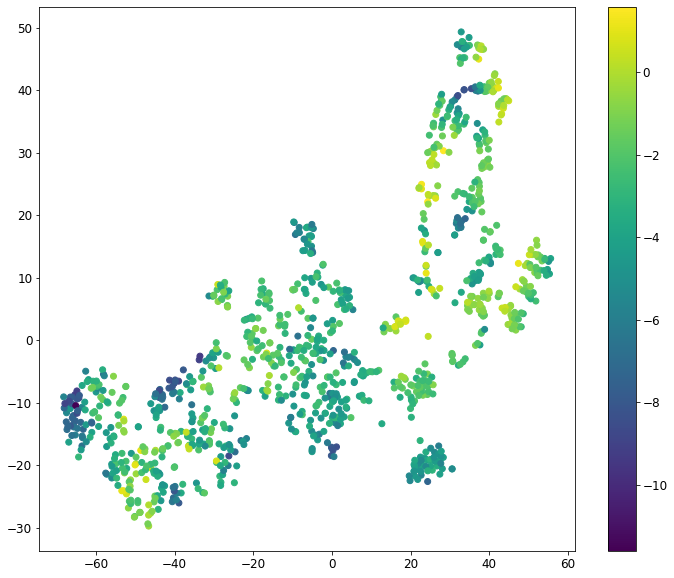

In [ ]:
fig = plt.figure(figsize=(12, 10))
plt.rcParams['font.size'] = 12
plt.scatter(X_esol_reduced[:, 0], X_esol_reduced[:, 1], c=y_esol, marker='o')
plt.colorbar()
plt.show()

**TO-DO**

Сделайте визуализацию для датасета Lipophilicity

In [ ]:
ts = TSNE(2) 
X_lip_reduced = ts.fit_transform(X_lip) 
y_lip = data_lip['exp'].values

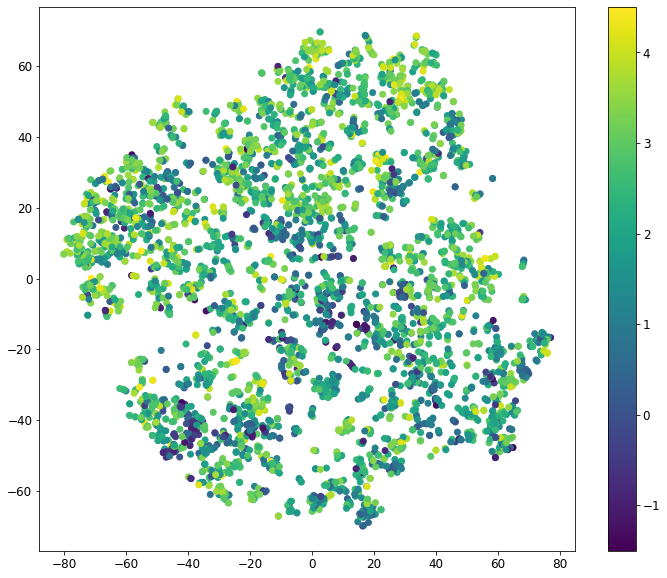

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.rcParams['font.size'] = 12
plt.scatter(X_lip_reduced[:, 0], X_lip_reduced[:, 1], c=y_lip, marker='o')
plt.colorbar()
plt.show()

Посмотрим, что за молекулы нарисованы на плоскости.

Выберем последовательность находящихся рядом молекул.
Для этого используем модель, которая подбирает ближайших соседей к точке

**TO-DO**:
1. Создайте объект NearestNeighbors, передайте аргумент metric='euclidean' (считаем расстояние по как евклидово)
2. Примените модель к X_esol_reduced (fit)
3. Задайте область, в которой будем искать соседей при помощи np.linspace (на вход принимает начало области по оси, конец области и количество точек). Размер области посмотрите по картинке с отрисованными векторами.

In [72]:
nn = NearestNeighbors(metric='euclidean') 
nn.fit(X_esol_reduced) 

xs = np.linspace(-60, 60, 12)
ys = np.linspace(-30, 50, 12)
ids = []
pts = []
for x,y in zip(xs, ys):
    _, result = nn.kneighbors([[x, y]], n_neighbors=1)
    ids.append(result[0, 0])
    pts.append(X_esol_reduced[result[0, 0]])
pts = np.array(pts)

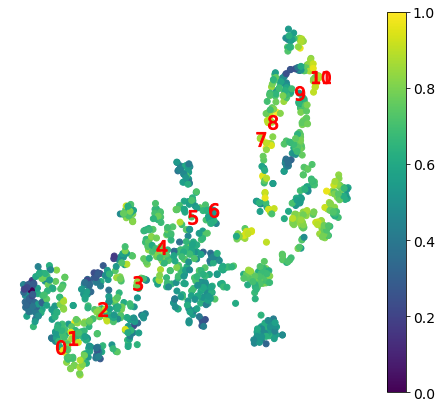

In [73]:

fig = plt.figure(figsize=(8,7))
plt.rcParams['font.size'] = 14
plt.axis('off')
plt.scatter(X_esol_reduced[:, 0], X_esol_reduced[:, 1], c=data['measured log solubility in mols per litre'].values, marker='o')
for i in range(12):
    plt.scatter(pts[i,0], pts[i,1], c='r', marker='${}$'.format(i), s=200*(1+i//10))
plt.colorbar()
plt.savefig('esol.png', dpi=300)
plt.show()

In [142]:
# функция отрисовки красивых молекул
def plot_mols(mols, unit=200, w=120, h=200, fontsize=1.0):
    drawer = Draw.MolDraw2DSVG(4*unit, 3*unit, w, h)

    opt = drawer.drawOptions()
    opt.padding = 1
    opt.legendFontSize = 20


    xs = np.array([0,1,2,3,0,1,2,3,0,1,2,3])*unit
    ys = np.array([0,0,0,0,1,1,1,1,2,2,2,2])*unit
    for i, (mol, x, y) in enumerate(zip(mols,xs,ys)):

        drawer.SetOffset(int(x), int(y))
        drawer.SetFontSize(fontsize)

        AllChem.Compute2DCoords(mol)
        Chem.Kekulize(mol)

        drawer.DrawMolecule(mol, legend=str(i))



    drawer.FinishDrawing()
    return drawer

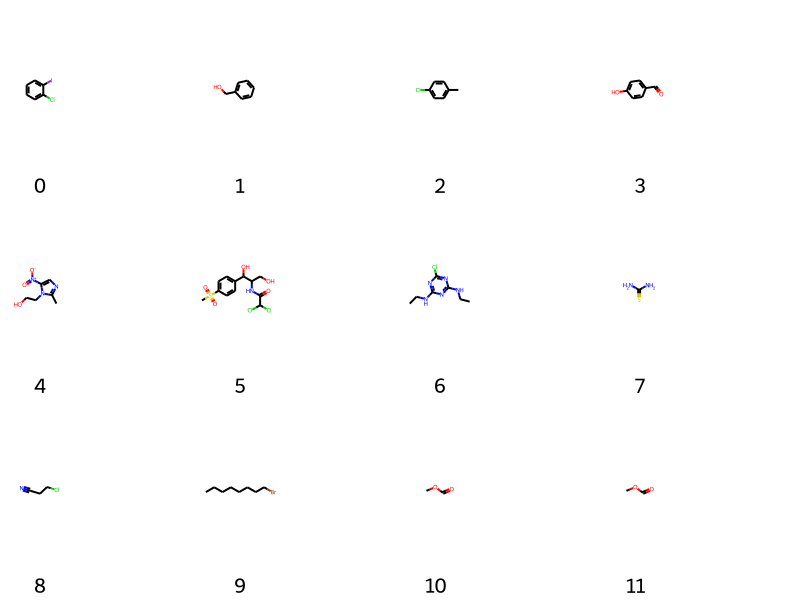

In [143]:
from IPython.display import SVG
mols = [Chem.MolFromSmiles(sm) for sm in data['smiles'].values[ids]]
dr = plot_mols(mols, w = 80)
with open('esol.svg', 'w') as f:
    f.write(dr.GetDrawingText())
SVG(dr.GetDrawingText())

Что вы видите на получившейся картинке?

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

def GetFeature(smi):
    mol = Chem.MolFromSmiles(smi)
    return mol.GetRingInfo().NumRings()

data['NumRings'] = data['smiles'].apply(GetFeature)
data_lip['NumRings'] = data_lip['smiles'].apply(GetFeature)

#ax = plt.subplot(121)
sns.kdeplot(data['NumRings'])

#ax = plt.subplot(122)
sns.kdeplot(data_lip['NumRings'], density=True)
plt.title('Number of Rings')
plt.legend(['Esol', 'Lypophilicity'])
plt.show()


NameError: ignored

In [116]:
!pip install git+https://github.com/bp-kelley/descriptastorus


  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-avcbgpe5
  Running command git clone -q https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-avcbgpe5
  Using cached pandas_flavor-0.2.0-py2.py3-none-any.whl (6.6 kB)
  Using cached xarray-0.18.0-py3-none-any.whl (801 kB)
  Created wheel for descriptastorus: filename=descriptastorus-2.3.0.2-py3-none-any.whl size=60174 sha256=6287ce2cfbe3a0cc20e8e0639fc33035912bad028fd7a05f2a4c886fa1fb7074
  Stored in directory: /tmp/pip-ephem-wheel-cache-4908el_p/wheels/f9/c3/4f/e7d01f4f2f1a89aef8f0ef088beb4a94976324f3ee21410b10
Successfully built descriptastorus


In [120]:
from descriptastorus.descriptors import rdDescriptors
from rdkit import Chem
import logging



generator = rdDescriptors.RDKit2D()


def rdkit_2d_features(smiles: str):
    # Достаньте свойства молекулы при помощи https://github.com/bp-kelley/descriptastorus
    features = generator.process(smiles)
    if not features[0]:
        print(f'{smiles} not processed')
        return None
    return features[1:]
    

def create_feature_dataframe(df, target):
    # сделайте датафрейм из всех свойств полученных генератором
    features_names = [gen[0] for gen in generator.columns]
    dicts = []
    for i in range(len(df)):
        x, y = df.iloc[i]['smiles'], df.iloc[i][target]
        features = rdkit_2d_features(x)
        dicts.append(dict(zip(features_names, features)))
        dicts[-1]['target'] = y
    df1 = pd.DataFrame(dicts)
    return df1



In [121]:
dt_esol_feats = create_feature_dataframe(data, 'measured log solubility in mols per litre')
dt_esol_feats.head()

dt_lipo_feats = create_feature_dataframe(data_lip, 'exp')
dt_lipo_feats.head()


BalabanJ      BertzCT       Chi0  ...  fr_urea       qed  target
0  1.420544   832.199002  16.518297  ...        0  0.728444    3.54
1  2.020016  1151.428500  24.172998  ...        0  0.545587   -1.18
2  1.943224   655.231463  14.819626  ...        0  0.807761    3.69
3  1.572408  1015.409752  19.836134  ...        0  0.506650    3.37
4  2.236144   902.250256  20.896977  ...        0  0.747686    3.10

[5 rows x 201 columns]

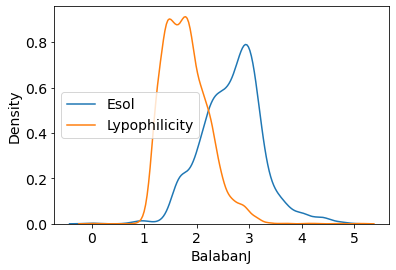

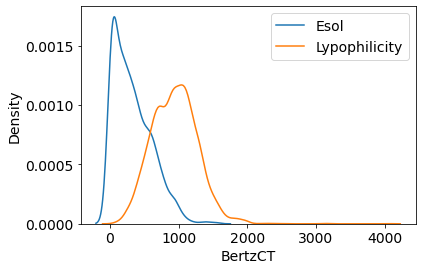

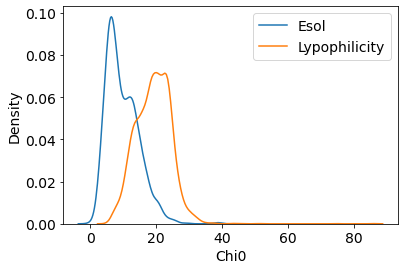

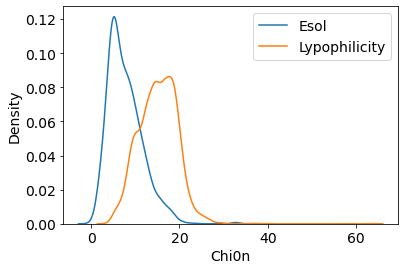

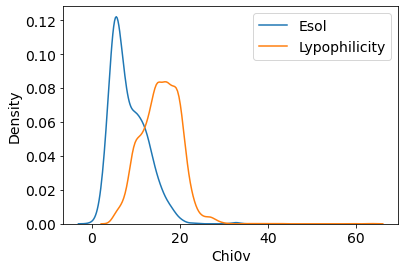

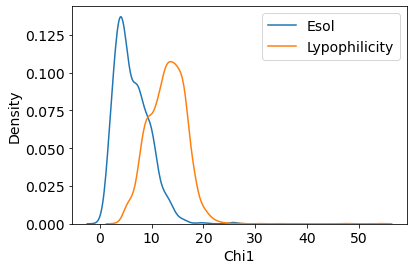

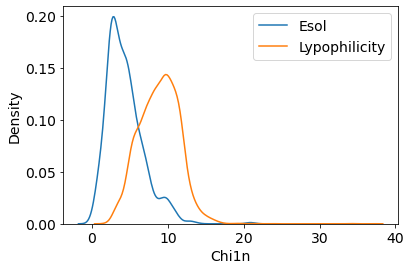

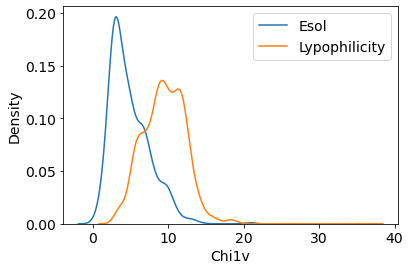

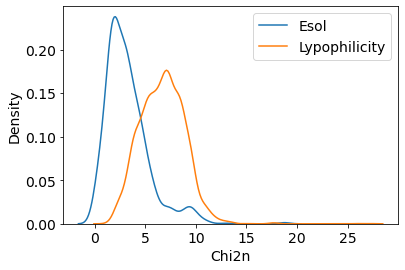

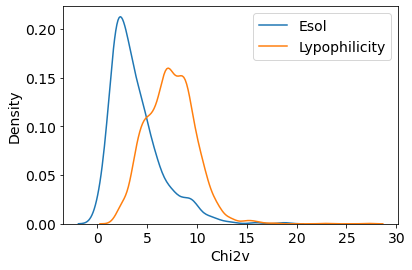

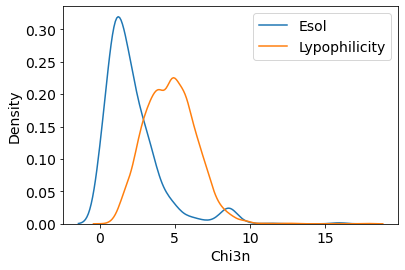

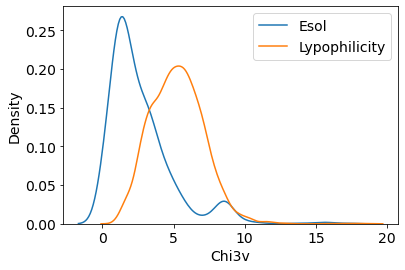

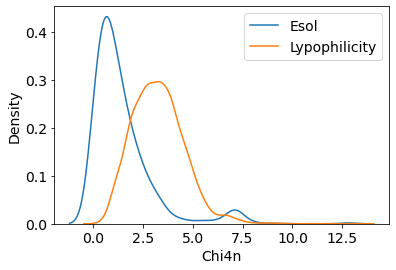

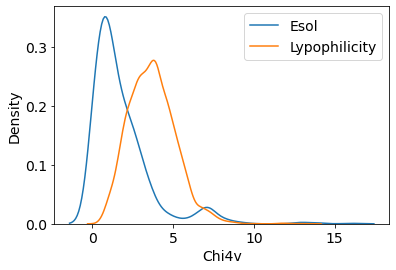

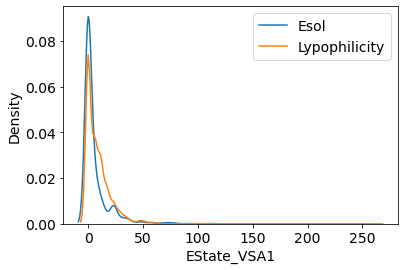

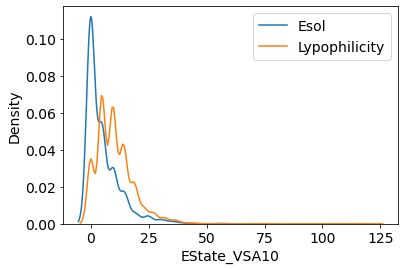

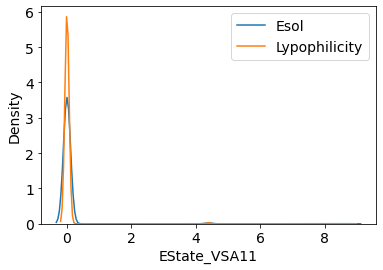

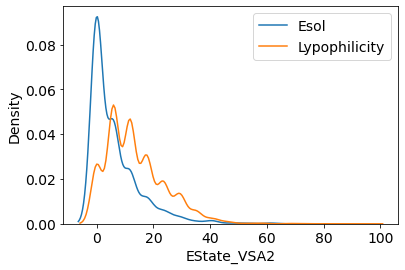

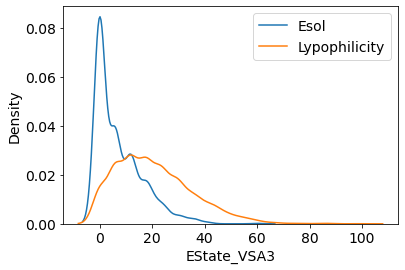

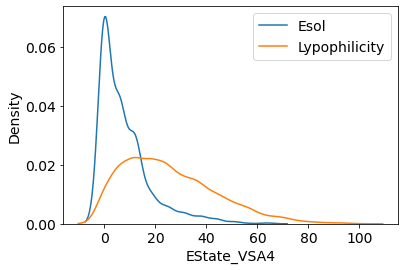

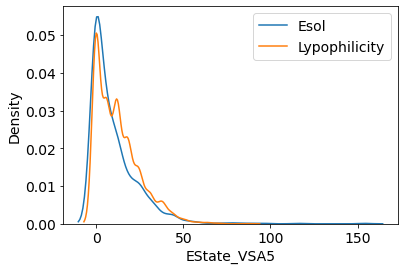

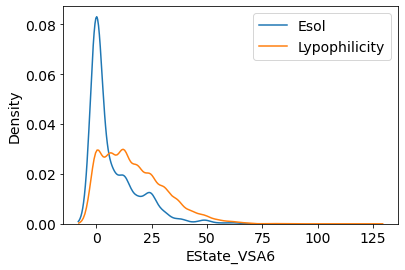

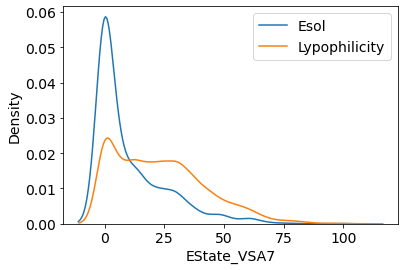

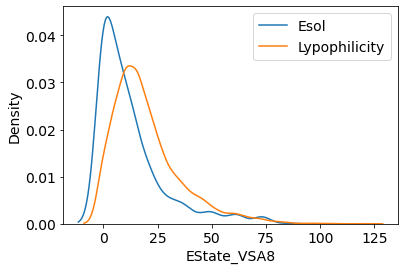

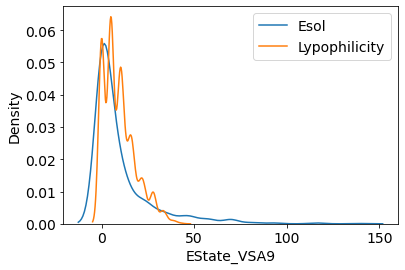

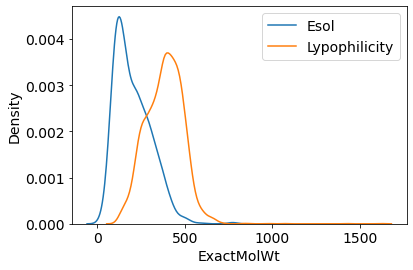

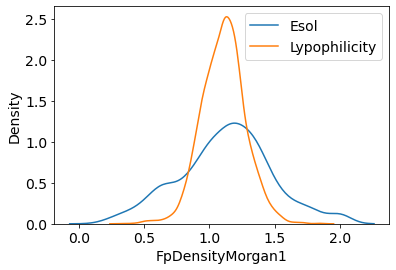

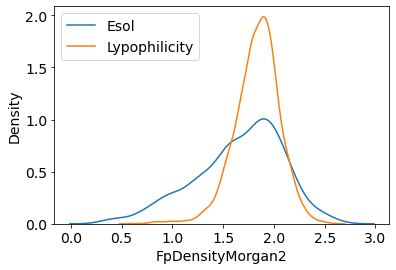

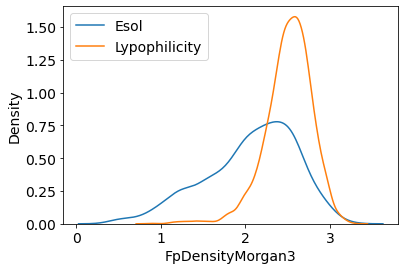

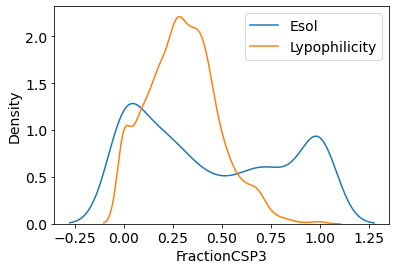

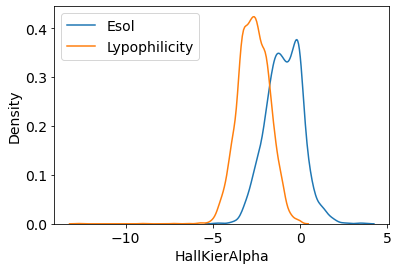

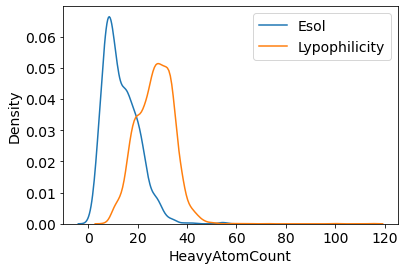

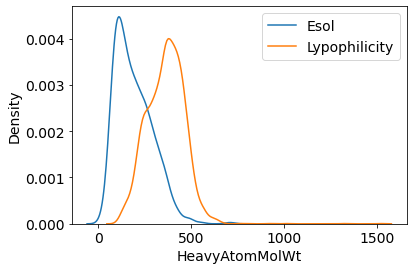

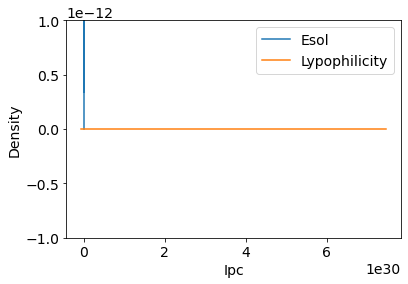

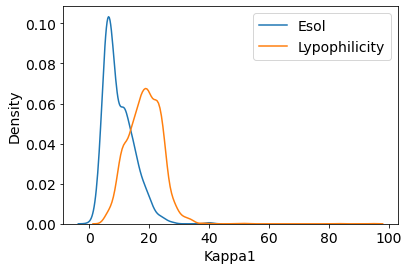

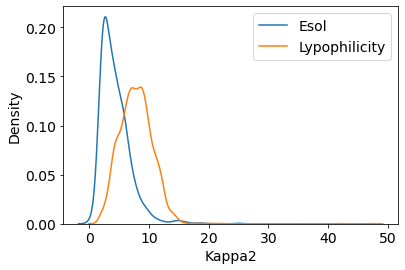

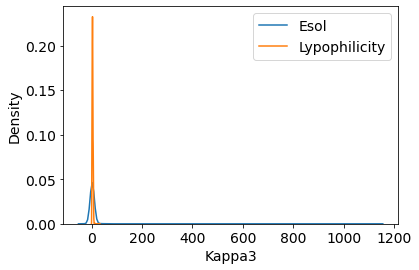

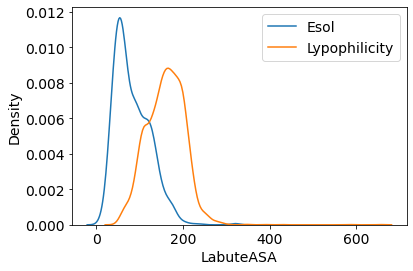

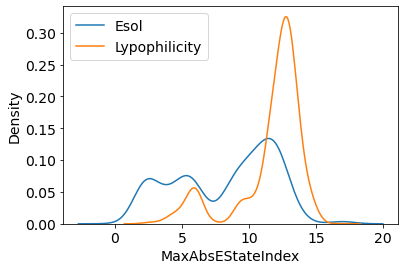

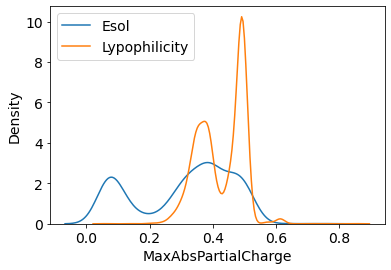

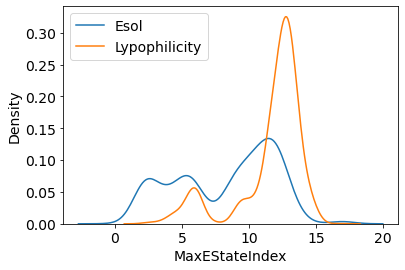

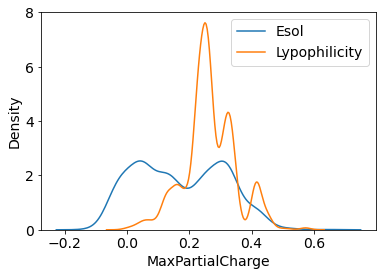

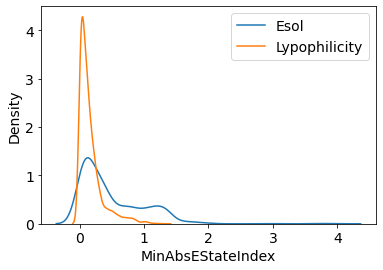

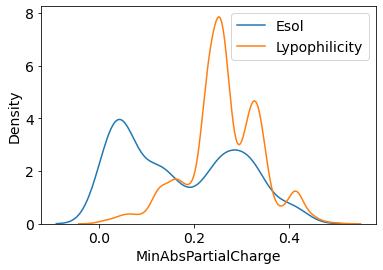

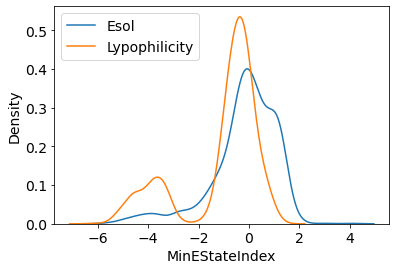

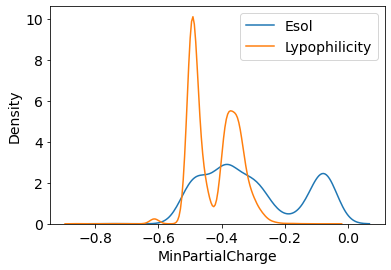

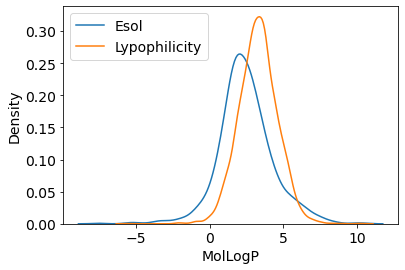

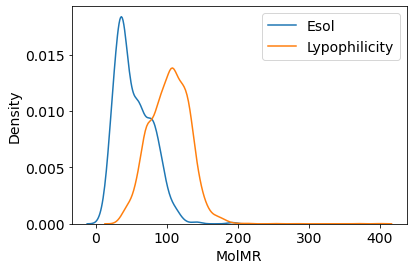

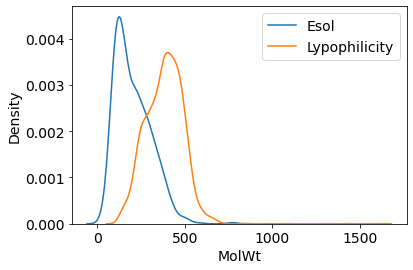

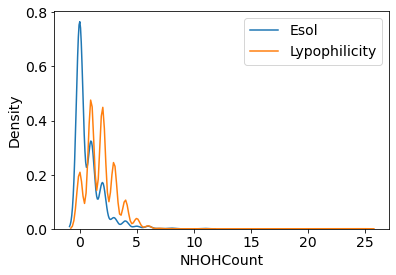

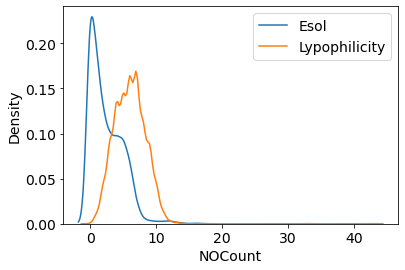

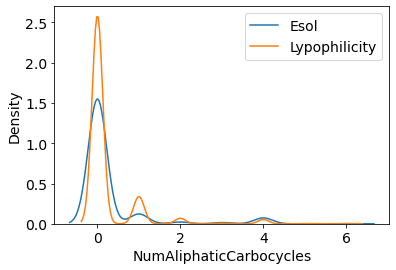

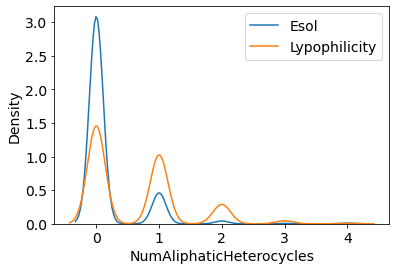

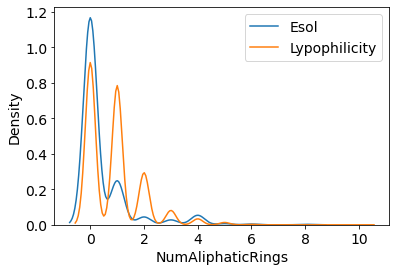

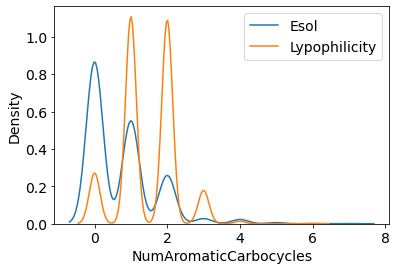

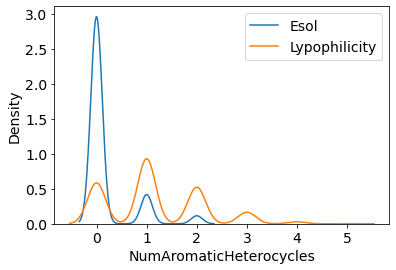

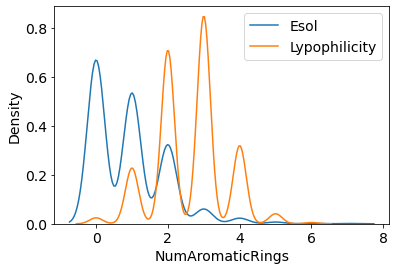

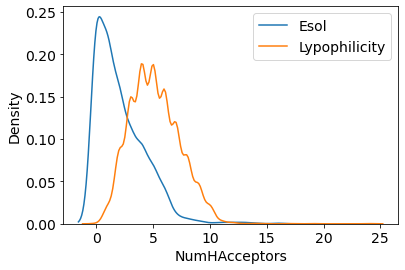

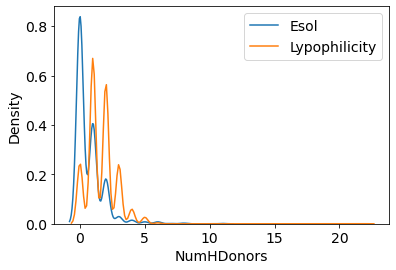

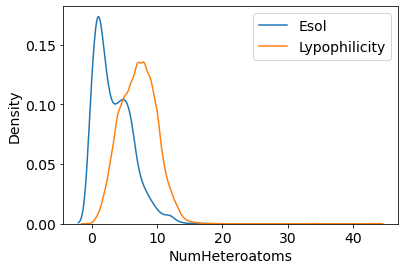

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


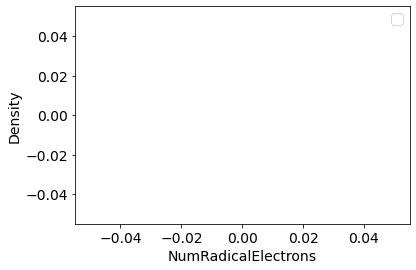

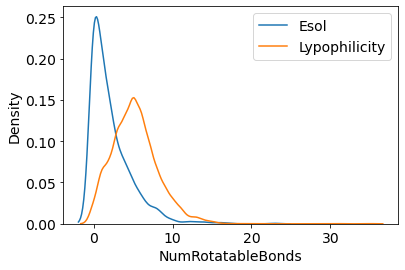

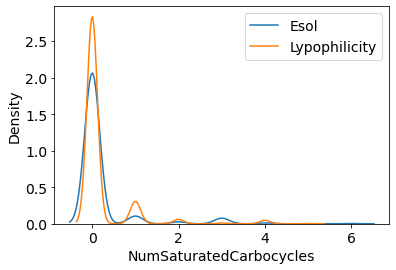

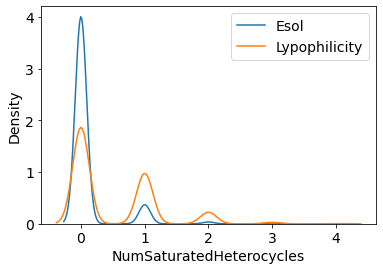

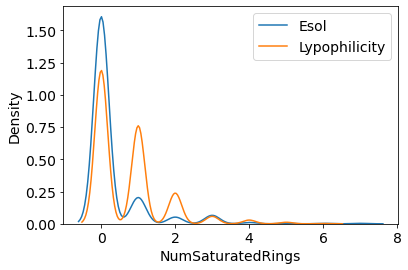

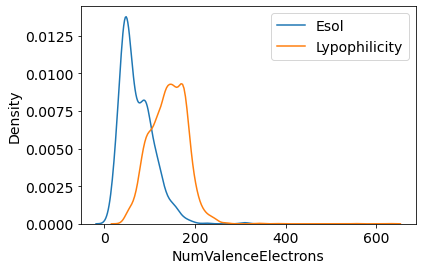

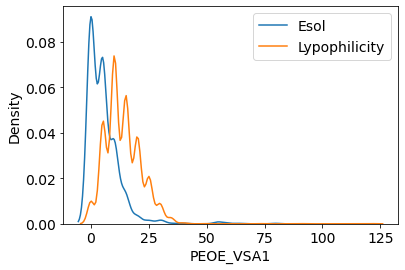

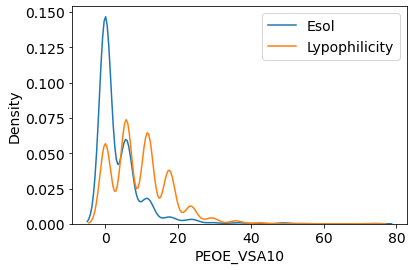

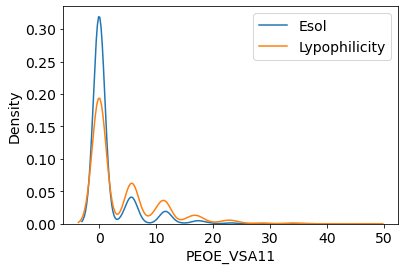

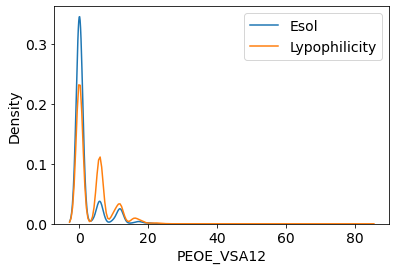

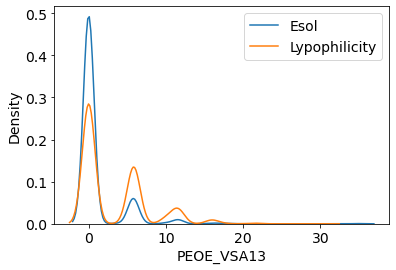

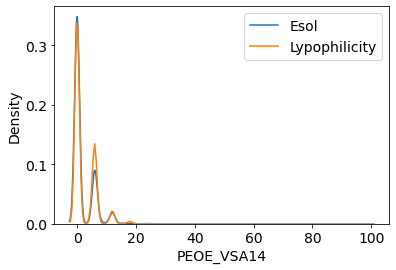

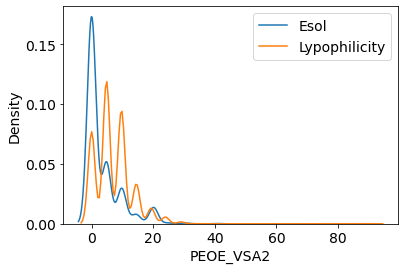

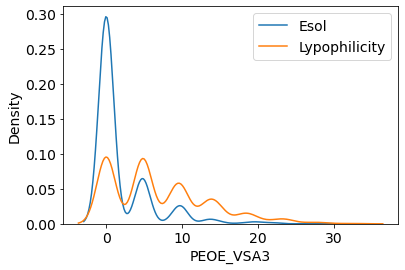

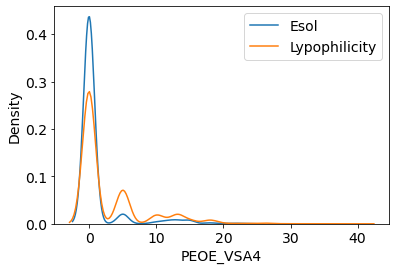

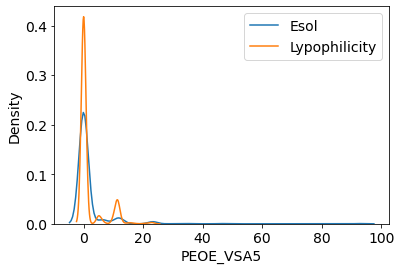

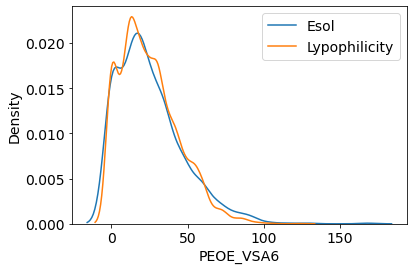

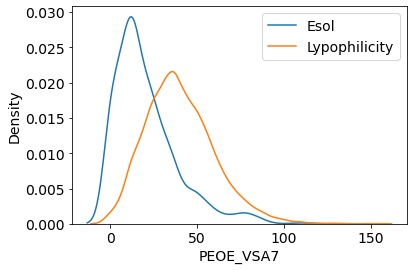

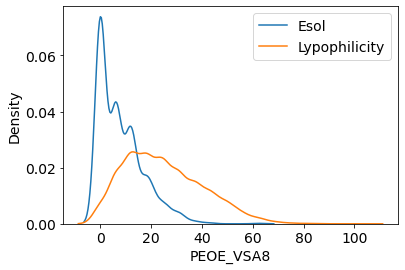

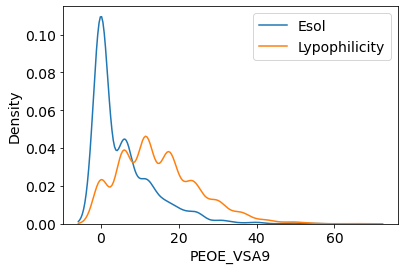

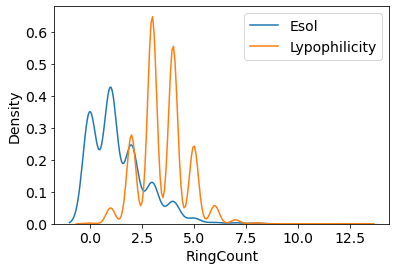

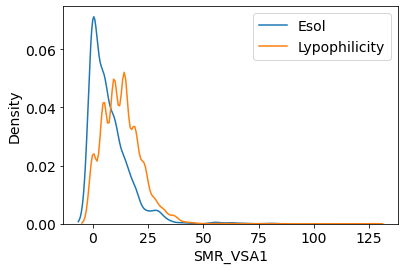

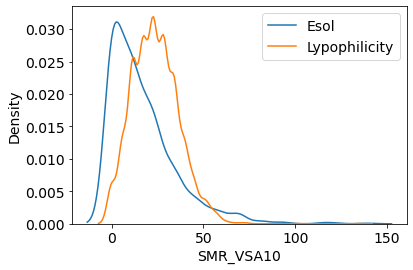

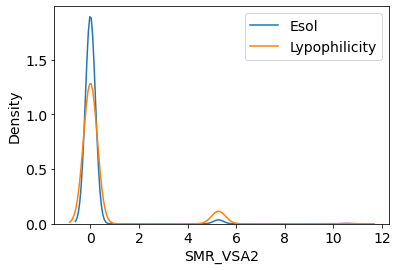

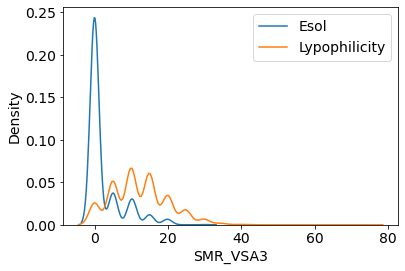

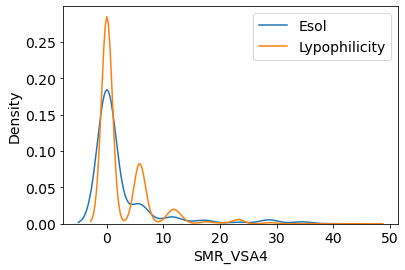

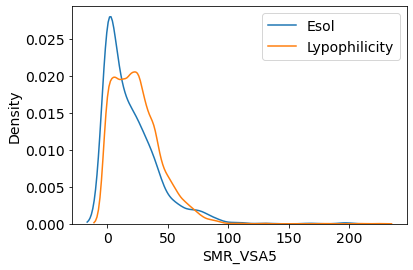

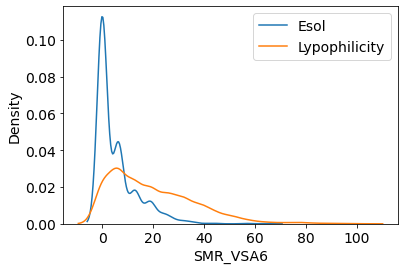

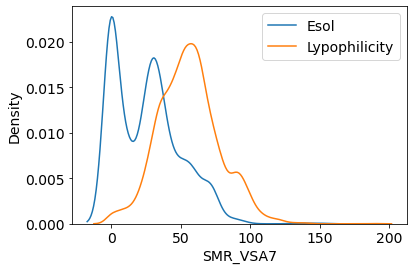

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


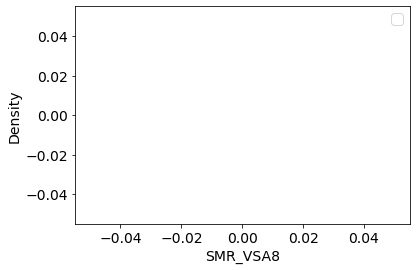

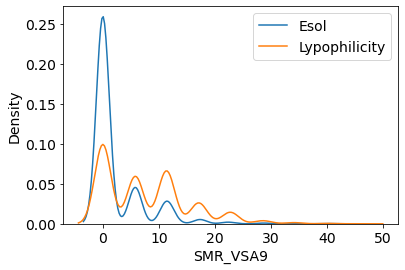

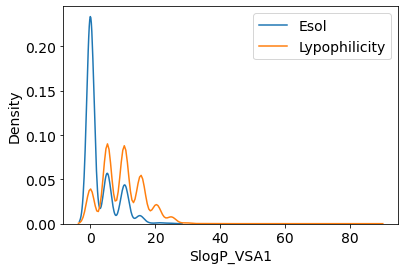

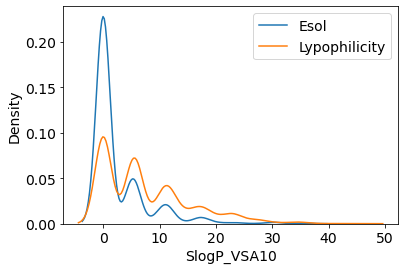

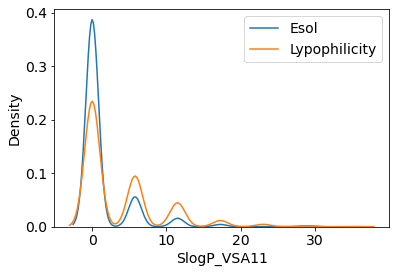

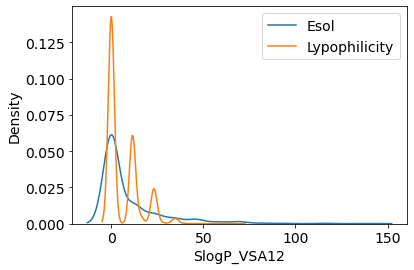

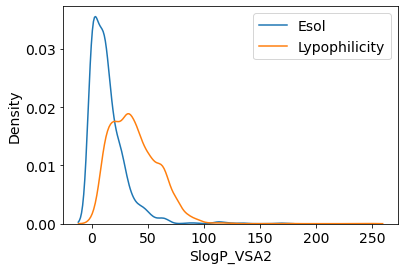

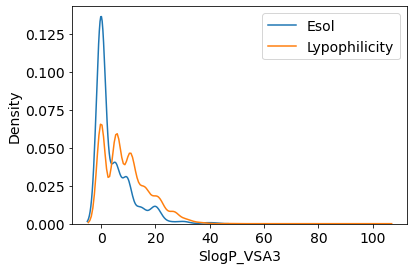

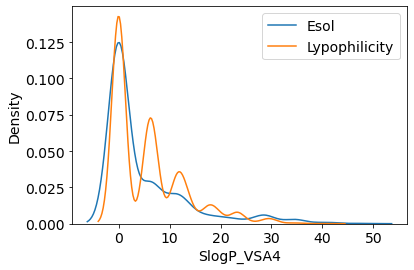

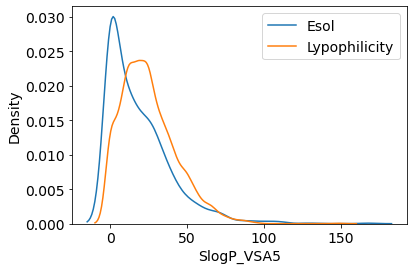

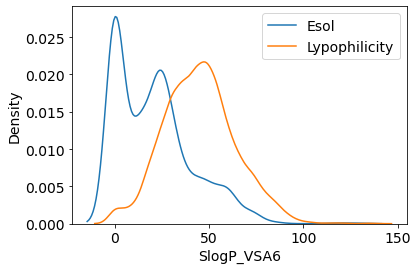

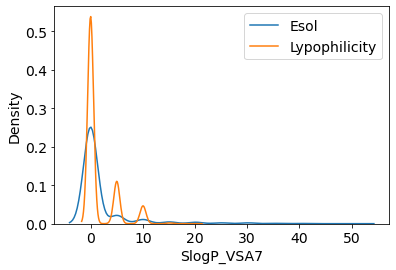

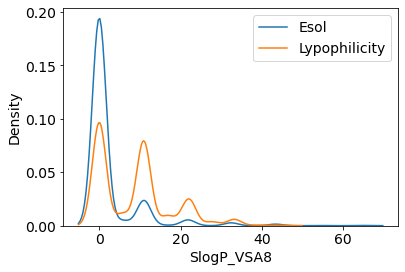

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


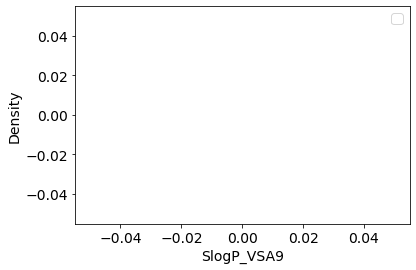

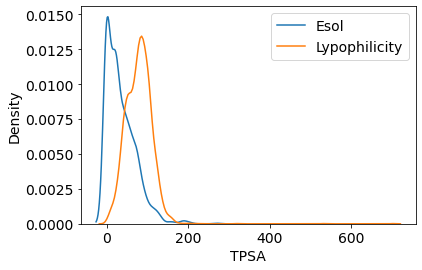

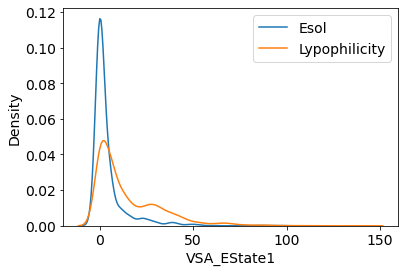

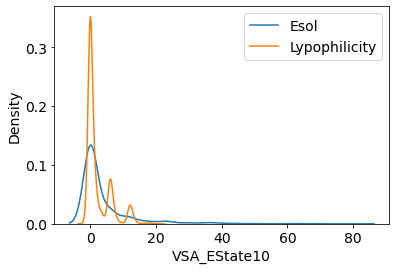

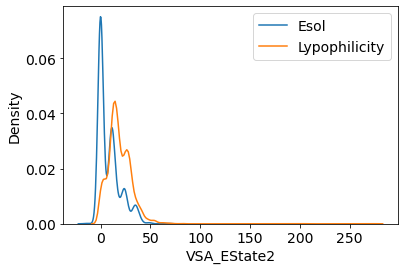

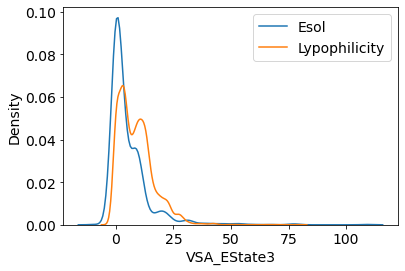

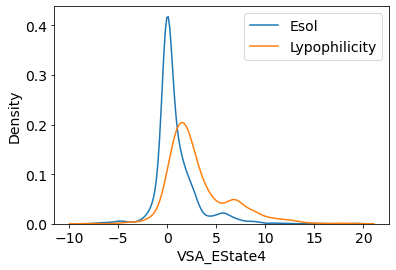

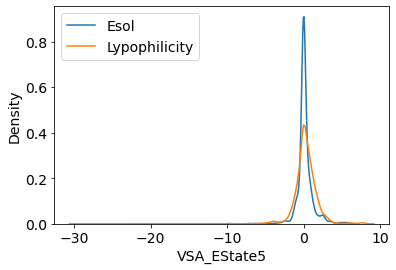

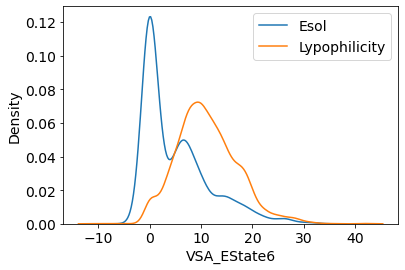

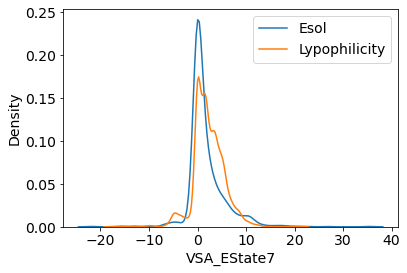

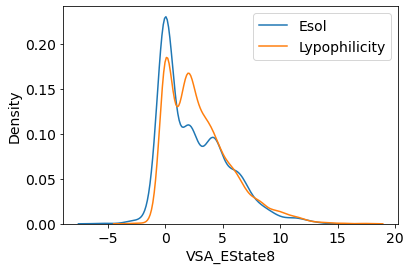

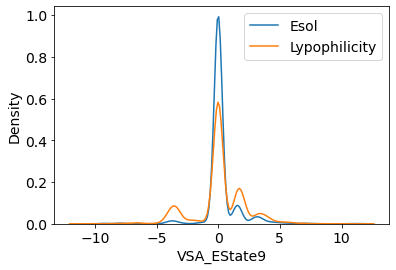

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


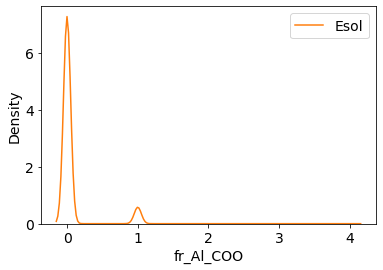

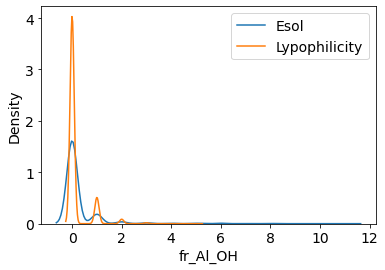

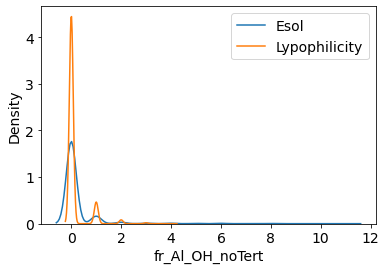

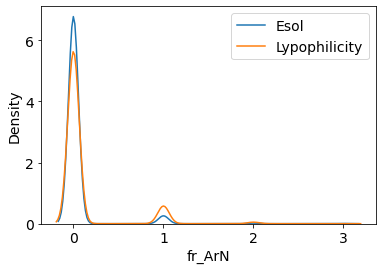

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


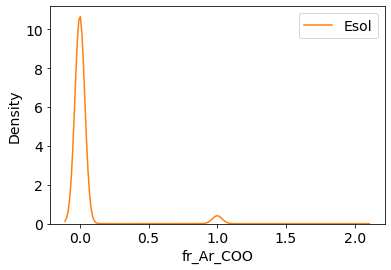

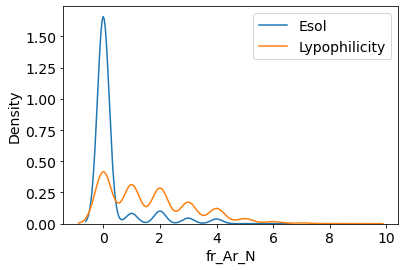

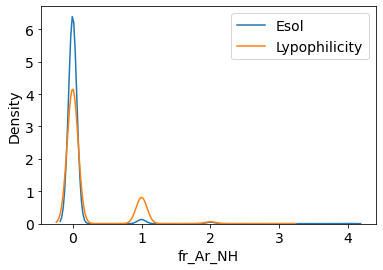

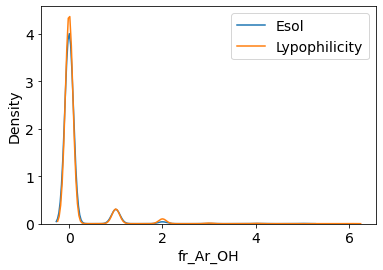

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


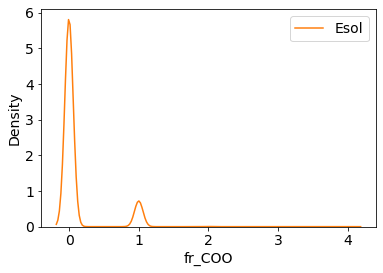

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


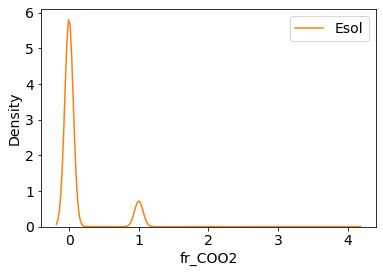

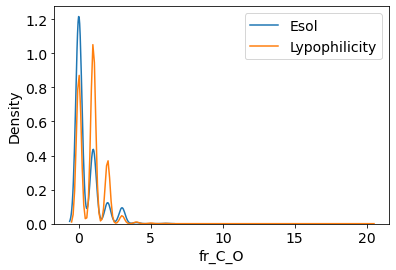

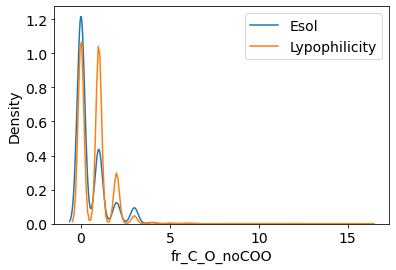

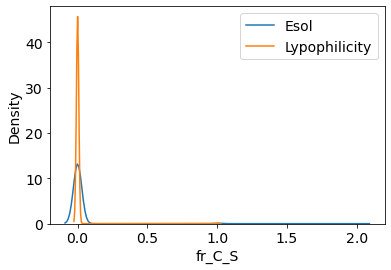

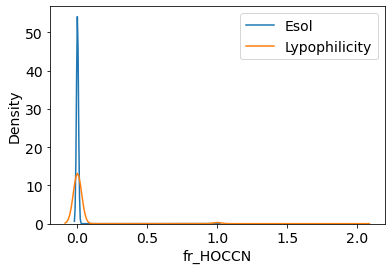

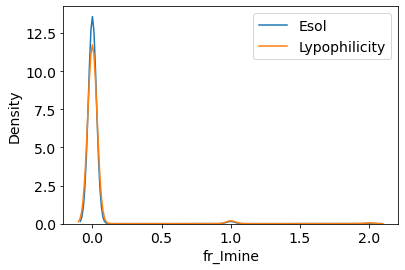

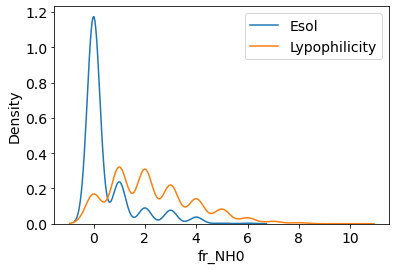

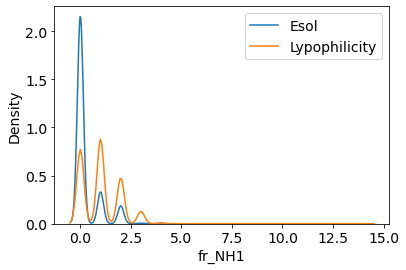

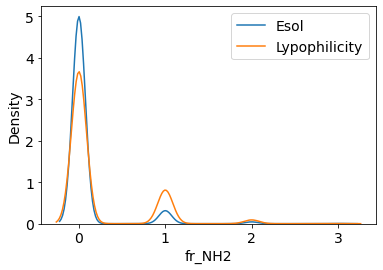

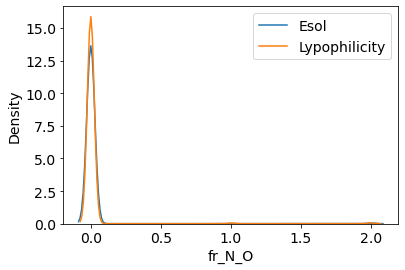

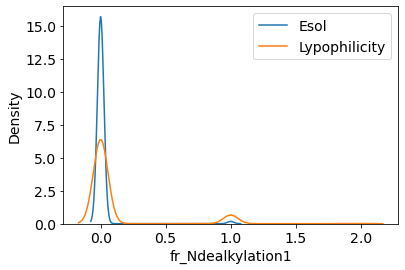

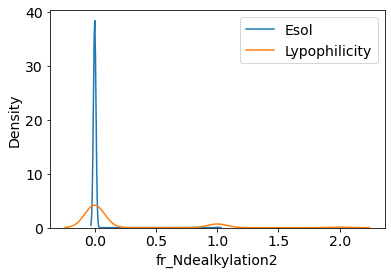

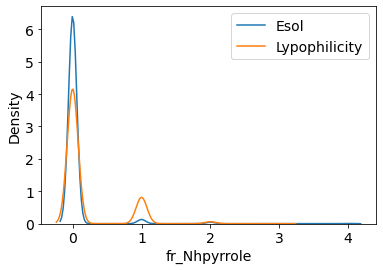

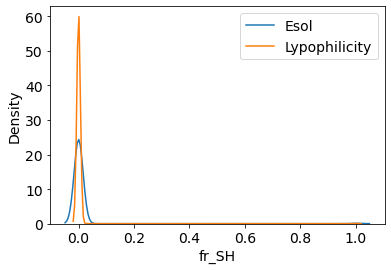

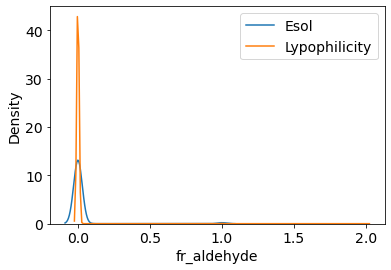

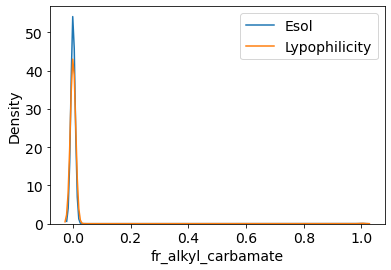

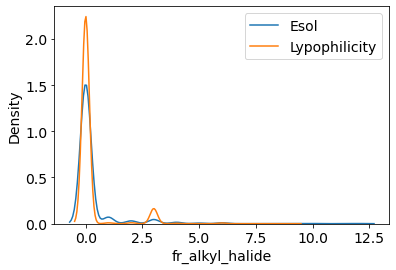

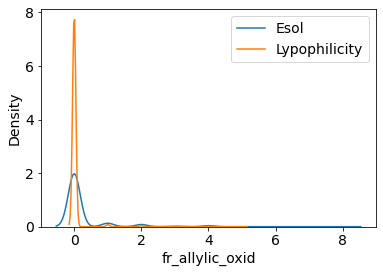

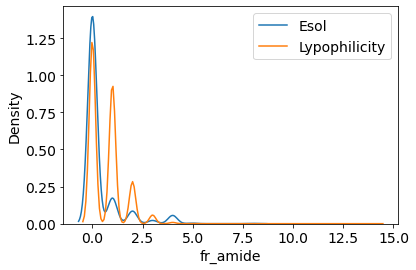

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


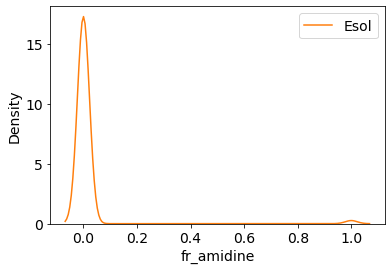

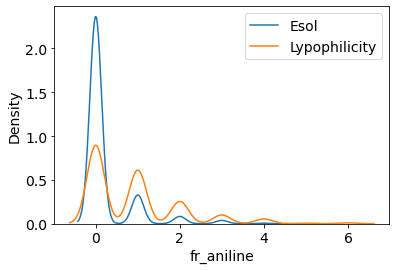

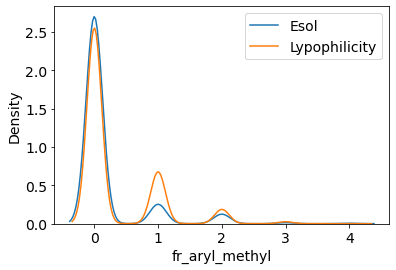

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


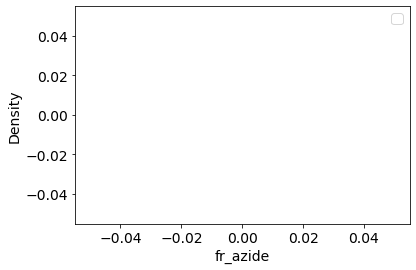

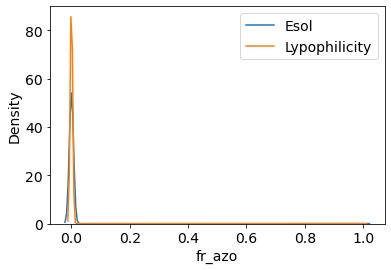

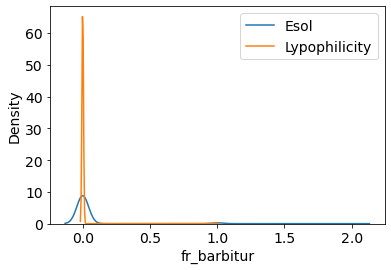

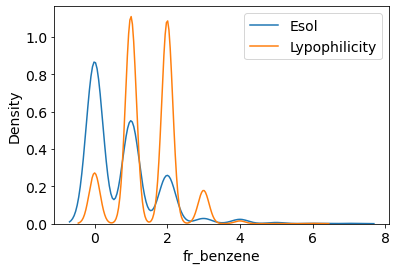

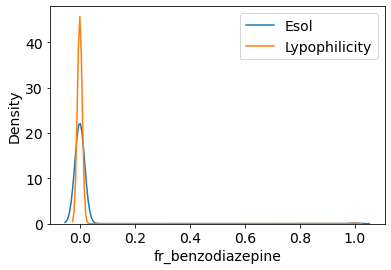

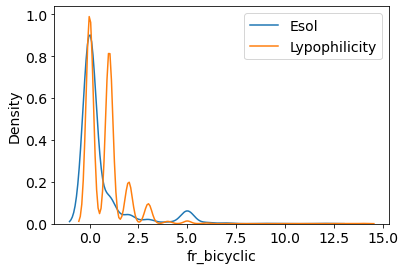

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


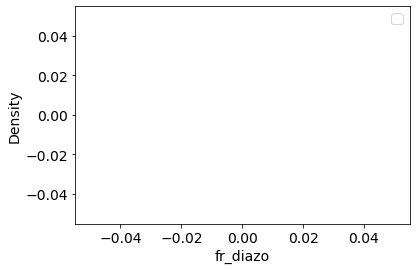

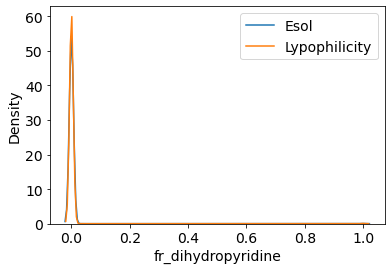

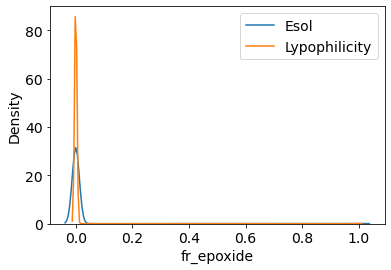

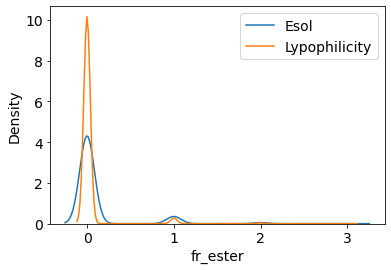

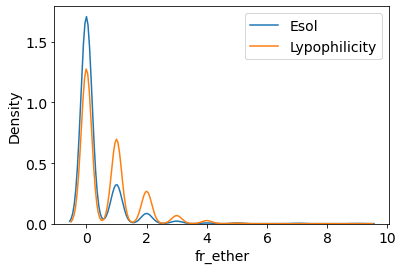

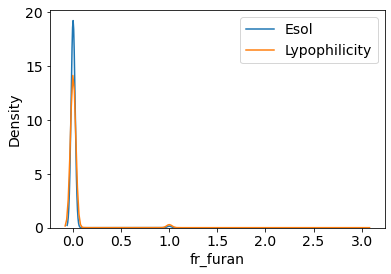

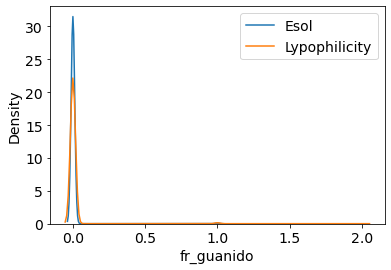

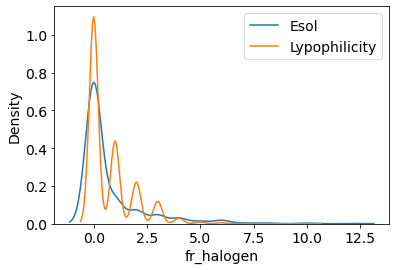

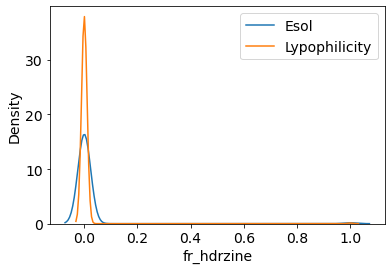

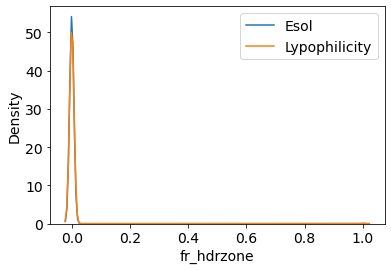

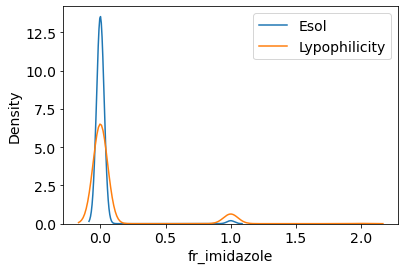

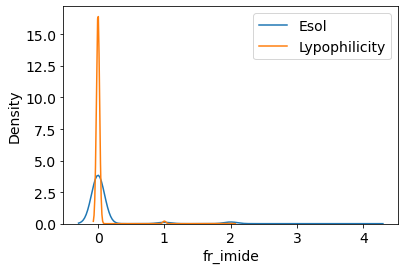

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


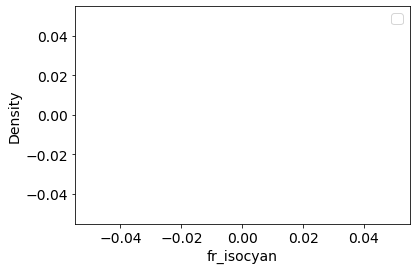

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


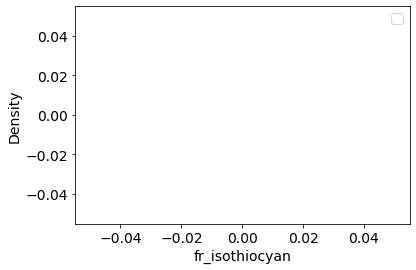

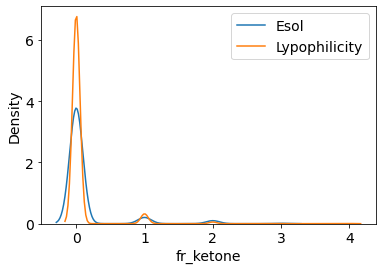

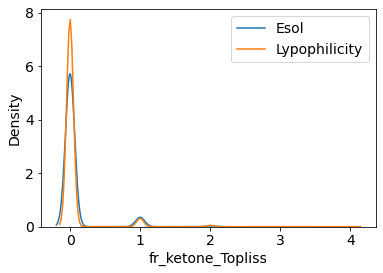

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


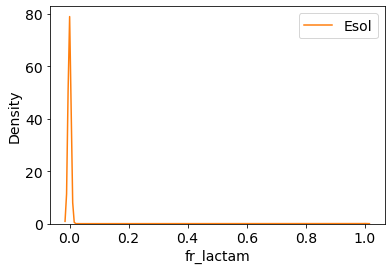

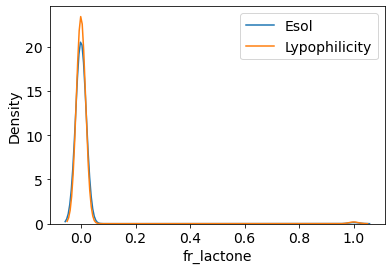

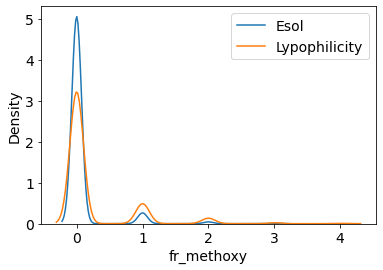

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


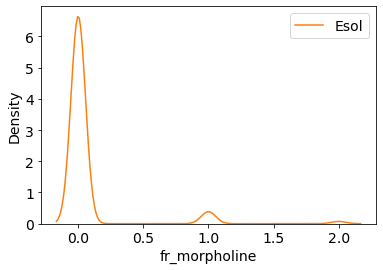

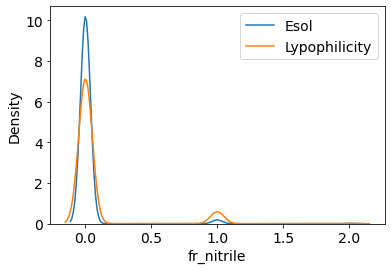

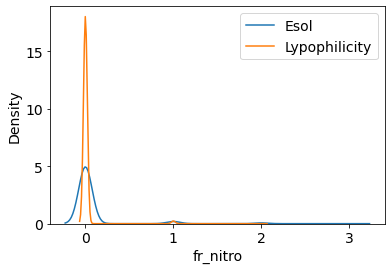

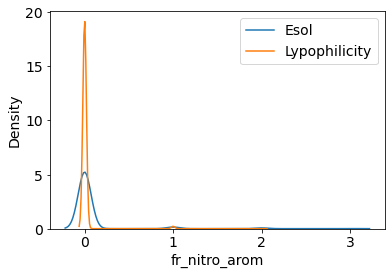

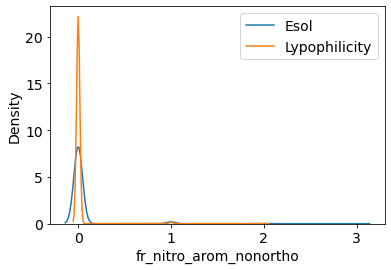

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


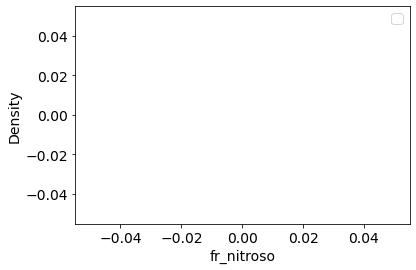

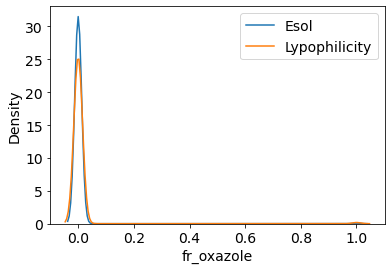

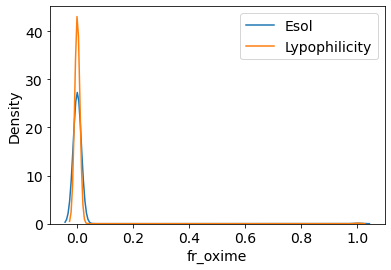

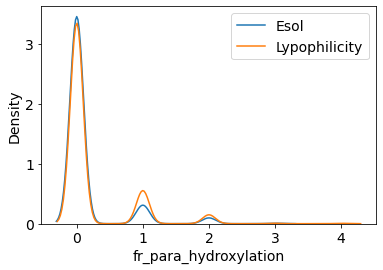

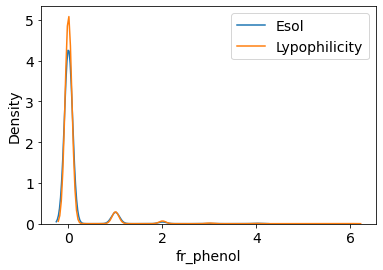

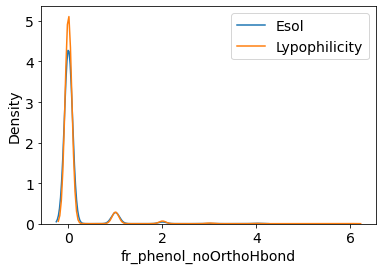

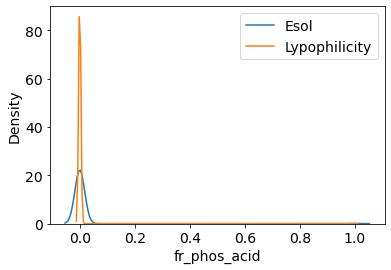

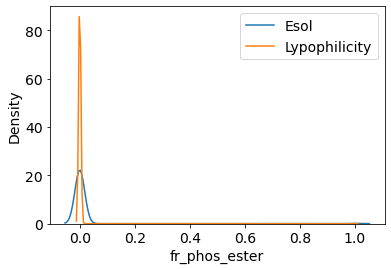

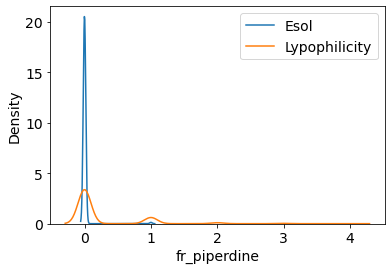

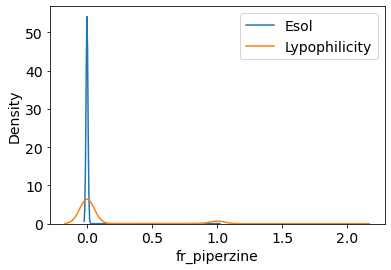

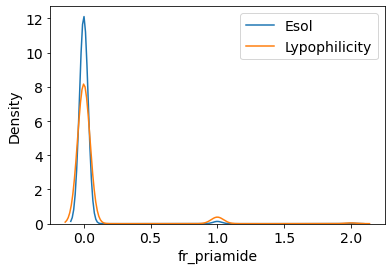

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


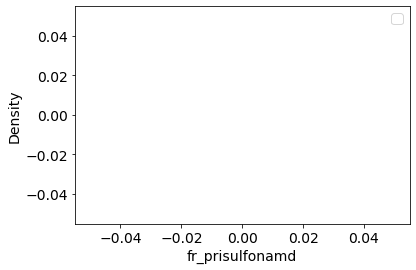

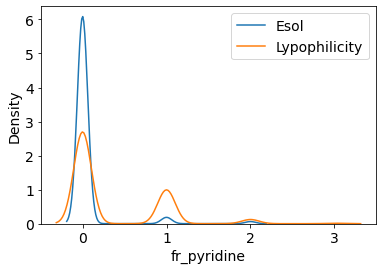

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


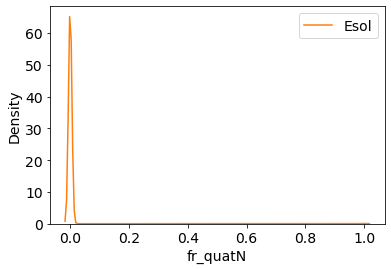

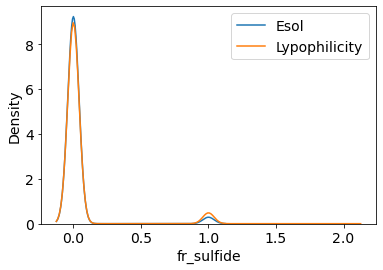

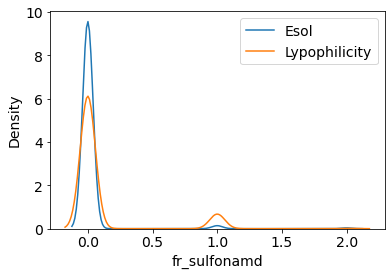

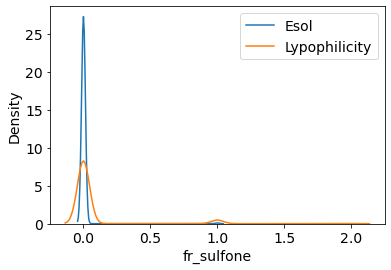

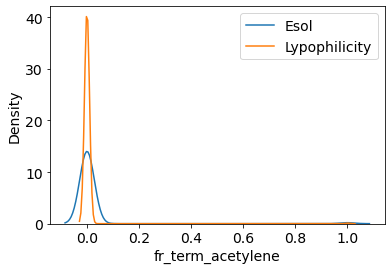

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


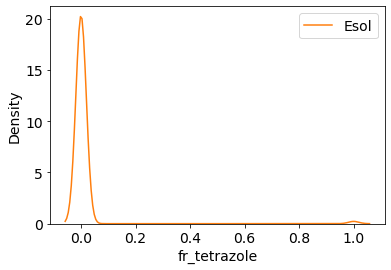

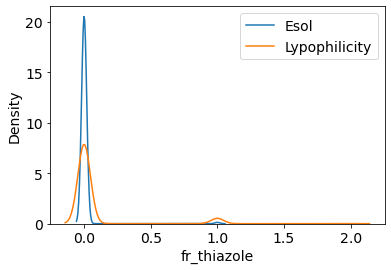

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


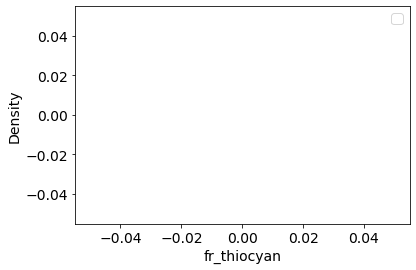

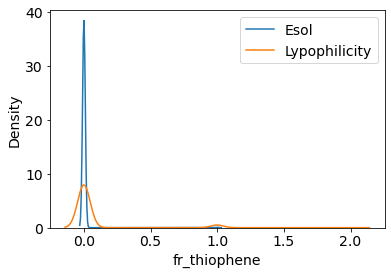

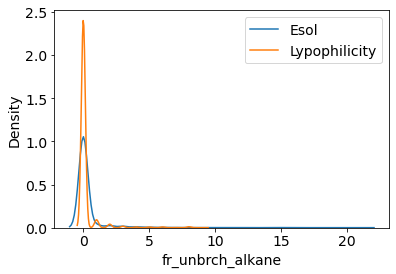

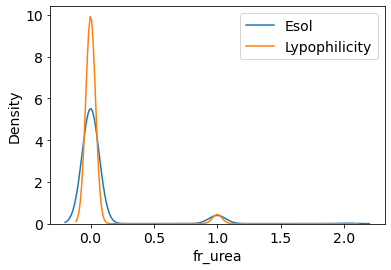

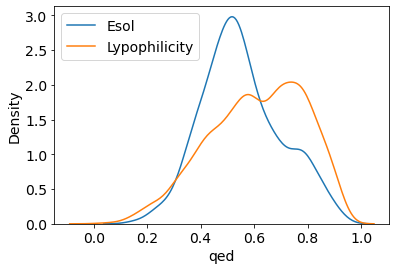

In [136]:
labels = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge', 'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'qed']

for lbl in labels:
    sns.kdeplot(dt_esol_feats[lbl])

    #ax = plt.subplot(122)
    sns.kdeplot(dt_lipo_feats[lbl])
    #plt.title(lbl)
    plt.legend(['Esol', 'Lypophilicity'])
    plt.show()
